## Training imports

In [1]:
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models

from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Accuracy, Precision, Recall, Loss, Metric
# from ignite.contrib.handlers import CosineAnnealingScheduler
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

from torch_lr_finder import LRFinder

/home/anant/anaconda3/envs/PT/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Get data and create augmentation transforms

In [2]:
composed = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.ToTensor()])

In [3]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

valid_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

## Create dataloaders

In [4]:
batch_size = 1500

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(len(train_loader))
for image, label in train_loader:
    print(image.shape, label.shape, image[0,0,:,:].max())
    break

40
torch.Size([1500, 1, 28, 28]) torch.Size([1500]) tensor(1.)


## Model declaration

In [7]:
class GlobalMaxPool2D(nn.Module):
    '''
    Reduce to feature space
    '''
    def __init__(self):
        super(GlobalMaxPool2D, self).__init__()
        
    def forward(self, x):
        x =  torch.max(torch.max(x, 3, keepdim=False)[0], 2, keepdim=False)[0]
        return x


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)

class CNNModel(nn.Module):
    def __init__(self, n_classes, debug=False):
        super(CNNModel, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = GlobalMaxPool2D()
        self.fc1 = nn.Linear(in_features=256, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout2d = nn.Dropout2d()
        self.dropout = nn.Dropout()
        self.flatten = Flatten()
        

        self.debug = debug
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        if self.debug:
            print(x.shape)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.dropout2d(x)
        if self.debug:
            print(x.shape)
        x = self.maxpool(self.relu(self.conv3(x)))
        if self.debug:
            print(x.shape)
        
        # x = self.global_maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)

        
        
        x = self.fc1(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)
        x = self.fc2(x)
        if self.debug:
            print(x.shape)

        
        return x
            
        
        

In [8]:
model = CNNModel(n_classes=10, debug=True)
for image, label in train_loader:
    print(image.shape, label.shape, image[0,0,:,:].max())
    out = model(image)
    break

torch.Size([1500, 1, 28, 28]) torch.Size([1500]) tensor(1.)
torch.Size([1500, 16, 13, 13])
torch.Size([1500, 32, 5, 5])
torch.Size([1500, 64, 2, 2])
torch.Size([1500, 256])
torch.Size([1500, 64])
torch.Size([1500, 10])


## LR range finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


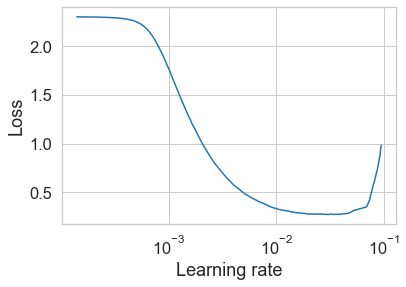

In [9]:
criterion = nn.CrossEntropyLoss()
model = CNNModel(n_classes=10, debug=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=500, diverge_th=5)
lr_finder.plot()

### Chosen learning rate

In [10]:
learning_rate = 5e-3

## Create callbacks

In [11]:
def create_callbacks(trainer, evaluator):
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        loss = trainer.state.output
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        
        print("Training Results - Epoch: {}  Training loss: {:.2f} Avg loss: {:.2f} Avg accuracy: {:.2f} Avg recall: {:.2f} Avg precision: {:.2f}".format(trainer.state.epoch,loss, metrics['loss'],
                                                                                                                 metrics['accuracy'], 
                                                                                                                 metrics['recall'],
                                                                                                                 metrics['precision']))

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_evaluator_on_validation_data(engine):
        evaluator.run(valid_loader)

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_trainer_on_training_data(engine):
        evaluator.run(train_loader)


## Metrics

In [18]:
def thresholded_output_transform(output, threshold=0.5):
    y_pred, y = output
    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_pred = torch.round(y_pred)
    return y_pred, y

In [19]:
is_multilabel = False
average = True

## Model declaration

In [20]:
model = CNNModel(n_classes=10, debug=False)

## Create ignite modules

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
trainer = create_supervised_trainer(model, optimizer, loss, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'loss': Loss(loss),
                                                                       'accuracy': Accuracy(thresholded_output_transform, 
                                                                                            is_multilabel=is_multilabel),
                                                                       'recall': Recall(thresholded_output_transform, 
                                                                                        is_multilabel=is_multilabel,
                                                                                        average=average),
                                                                       'precision': Precision(thresholded_output_transform, 
                                                                                              is_multilabel=is_multilabel,
                                                                                              average=average)})
create_callbacks(trainer, evaluator)

## Training

In [23]:
trainer.run(train_loader, max_epochs=10)

Training Results - Epoch: 1  Training loss: 0.39 Avg loss: 0.19 Avg accuracy: 0.94 Avg recall: 0.94 Avg precision: 0.94
Training Results - Epoch: 2  Training loss: 0.27 Avg loss: 0.10 Avg accuracy: 0.97 Avg recall: 0.97 Avg precision: 0.97
Training Results - Epoch: 3  Training loss: 0.22 Avg loss: 0.08 Avg accuracy: 0.98 Avg recall: 0.98 Avg precision: 0.98
Training Results - Epoch: 4  Training loss: 0.15 Avg loss: 0.06 Avg accuracy: 0.98 Avg recall: 0.98 Avg precision: 0.98
Training Results - Epoch: 5  Training loss: 0.15 Avg loss: 0.05 Avg accuracy: 0.98 Avg recall: 0.98 Avg precision: 0.98
Training Results - Epoch: 6  Training loss: 0.15 Avg loss: 0.05 Avg accuracy: 0.98 Avg recall: 0.98 Avg precision: 0.98
Training Results - Epoch: 7  Training loss: 0.12 Avg loss: 0.04 Avg accuracy: 0.98 Avg recall: 0.98 Avg precision: 0.98
Training Results - Epoch: 8  Training loss: 0.13 Avg loss: 0.04 Avg accuracy: 0.99 Avg recall: 0.99 Avg precision: 0.99
Training Results - Epoch: 9  Training lo